In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web # Doesn't seem to work
import yfinance as yf
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

In [71]:
# Load the data
company = 'META'

start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

data = yf.download(company, start=start, end=end)
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-05-18  42.049999  45.000000  38.000000  38.230000  38.151600  573576400
2012-05-21  36.529999  36.660000  33.000000  34.029999  33.960213  168192700
2012-05-22  32.610001  33.590000  30.940001  31.000000  30.936428  101786600
2012-05-23  31.370001  32.500000  31.360001  32.000000  31.934378   73600000
2012-05-24  32.950001  33.209999  31.770000  33.029999  32.962265   50237200


In [72]:
# Prepare the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1)) # Reshape the data to a 2D array, we scale the data to values between 0 and 1

In [73]:
prediction_days = 60 # How many days we want to use to predict the future
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0]) # we substract the prediction_days from x to get the previous 60 days
    y_train.append(scaled_data[x, 0]) 

x_train, y_train = np.array(x_train), np.array(y_train) # Convert the data to numpy arrays
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # we need to reshape the data to 3D array to be able to use it in the 
# LSTM model since it expects a 3D array because it has 3 dimensions: number of samples, number of timesteps, and number of features

In [74]:
import torch

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__() # LSTMModel inherits from nn.Module
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # h0 represents the initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # c0 represents the initial cell state

        # cell states are used to remember the context
        # hidden states are used to remember the previous values

        out, _ = self.lstm(x, (h0, c0)) # LSTM output is a tuple of output and the hidden states
        out = self.dropout(out[:, -1, :]) 
        out = self.fc(out)
        return out

# Hyperparameters
input_size = 1
hidden_size = 50
num_layers = 3
output_size = 1
dropout_rate = 0.2
learning_rate = 0.001
num_epochs = 20
batch_size = 32 

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert numpy arrays to PyTorch tensors
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train).view(-1, 1)  # Reshape y_train to (num_samples, 1)

# Create dataset and dataloader
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.0541
Epoch [2/20], Loss: 0.0000
Epoch [3/20], Loss: 0.0169
Epoch [4/20], Loss: 0.0000
Epoch [5/20], Loss: 0.0007
Epoch [6/20], Loss: 0.0006
Epoch [7/20], Loss: 0.0001
Epoch [8/20], Loss: 0.0116
Epoch [9/20], Loss: 0.0001
Epoch [10/20], Loss: 0.0092
Epoch [11/20], Loss: 0.0000
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 0.0041
Epoch [14/20], Loss: 0.0003
Epoch [15/20], Loss: 0.0000
Epoch [16/20], Loss: 0.0001
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0055
Epoch [20/20], Loss: 0.0000


In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(device)

cuda


In [76]:
# Load the test data
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values # Get the actual prices from the test data

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0) # Axis represents the direction in which the data is concatenated, 0 means vertically, 1 means horizontally
# in this case we want vertical concatenation since we want to add the test data below the training data

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1) 
model_inputs = scaler.transform(model_inputs)

[*********************100%%**********************]  1 of 1 completed


In [77]:
# Make predictions on test data

model.eval()

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test = torch.tensor(x_test, dtype=torch.float32).to(device) # Convert the data to PyTorch tensor and move it to the device

model.eval()

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [78]:
batch_size = 32
predictions = []

with torch.no_grad():
    for i in range(0, len(x_test), batch_size):
        batch_x = x_test[i:i+batch_size]
        outputs = model(batch_x)
        predictions.append(outputs)

predictions = torch.cat(predictions, dim=0).cpu().numpy() # we use cpu to move the data to the cpu and then convert it to numpy array

try: 
    predictions = scaler.inverse_transform(predictions)
except ValueError as e:
    print(f"Error: {e}")
    print(f"Shape of predictions: {predictions.shape}")
    print(f"Sample of predictions: {predictions[:5]}")

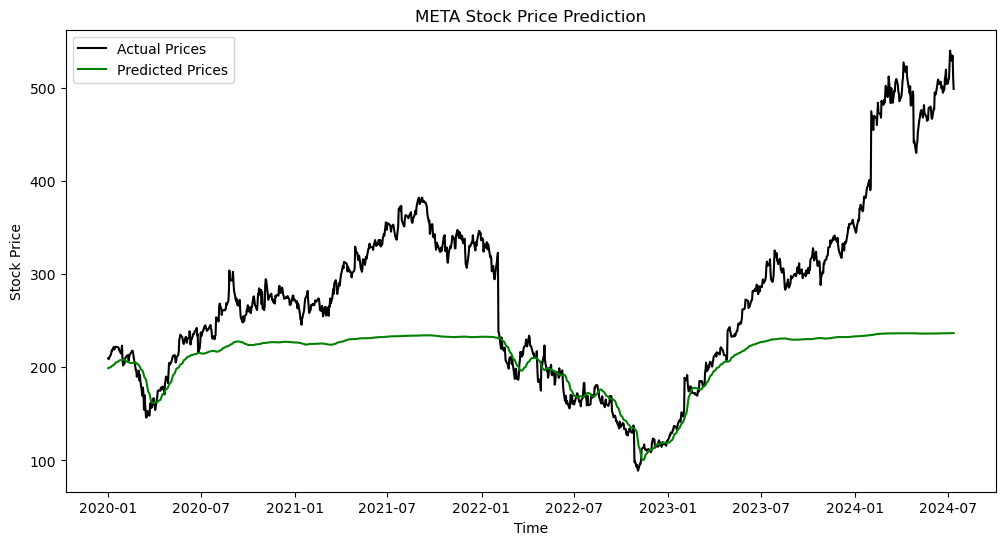

In [79]:
plt.figure(figsize=(12,6))
plt.plot(test_data.index, actual_prices, color="black", label="Actual Prices")
plt.plot(test_data.index, predictions, color="green", label="Predicted Prices")
plt.title(f"{company} Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [80]:
# Predict the next day
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
real_data = torch.FloatTensor(real_data).to(device)

In [81]:
with torch.no_grad():
    predictions = model(real_data)

predictions = predictions.cpu().numpy()
predictions = scaler.inverse_transform(predictions)
print(f"Prediction for the next day: {predictions[0][0]}")

Prediction for the next day: 236.6442108154297


### Lesson Learned
- We cannot import Layers like Tensorflow and Models like Sequential
- It is important to reshape input data
- fc is a layer that is fully connected: we use it to flatten the input data